# Denoising Autoencoder
We will be applying a noise filter to MNIST images and using a denoising autoencoder to reconstruct the original image.

![image.png](https://miro.medium.com/max/1400/1*MMRDQ4g3QvQNc7iJsKM9pg@2x.png)

## Lets Get Started!

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

We will be implementing the diagram below. To learn more, read the following: http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/. The first few paragraphs should suffice to get a basic understanding of what an autoencoder is.

![image.png](https://miro.medium.com/max/1400/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)

As seen in the first figure, a denoising autoencoder takes some noisy image and tries to reconstruct the original image. We will be attempting to reconstruct noisy MNIST images. function to apply a mask to each input X. 

In [14]:
from numpy.core.shape_base import vstack
def masking_noise(X, v):
    """ Apply masking noise to data in X, in other words a fraction v of elements of X
    (chosen at random) is forced to zero.
    X is of size [batch_size, features]
    """
    X_noise = X.clone().detach()
    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    for i in range(n_samples):
        mask = np.random.choice(n_features, size=round(n_features*v))
        for m in mask:
            X_noise[i][m] = 0
    return X_noise

### Network parameters and Hyperparameters

In [15]:
# Parameters
learning_rate = 0.01
training_epochs = 50
batch_size = 64

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28) NOTE: no 3rd dimension b/c B&W

Fill in the encoder and decoder blocks, and then complete the forward method:
* The encoder block takes in a noisy image and returns a 128 dimensional tensor (the middle layer)
* The decoder block takes in the middle layer of the network and outputs the restored image

*(hint: nn.Sequential)*

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(n_input, n_hidden_1),
                                     nn.ReLU(),
                                     nn.Linear(n_hidden_1, n_hidden_2),
                                     nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(n_hidden_2, n_hidden_1),
                                     nn.ReLU(),
                                     nn.Linear(n_hidden_1, n_input),
                                     nn.Sigmoid())
        
    def forward(self, input):
        encoded_input = self.encoder(input)
        out = self.decoder(encoded_input)
        return out

*Side Note:* If you have CUDA enabled and would like to place computations on an available GPU (or distribute over multiple), PyTorch gives each tensor the attribute "device", which can be changed to the desired GPU(s). To learn more, please see the article below.
https://towardsdatascience.com/speed-up-your-algorithms-part-1-pytorch-56d8a4ae7051

In [17]:
# Print out the number of GPUs that are available
if torch.cuda.is_available():
    print(torch.cuda.device_count(), "gpus available")
    device = torch.device(0)
else:
    print('no gpus available')

no gpus available


Initialize the autoencoder model.

In [18]:
model = Model()
print(model)

Model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


Define the loss criterion for the model as Binary Cross Entropy loss (look through PyTorch documentation). This will be called later during the training loop.

In [19]:
criterion = nn.BCELoss()

Define the optimizer as the Adam optimizer which will be used to minimize the loss defined above.

In [20]:
optimizer = torch.optim.Adam(model.parameters())

Define a DataLoader for use in the training loop. This dataset/dataloader setup in PyTorch is extremely helpful and good to know. It is possible to create custom datasets pretty easily.
https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

*Note: you may have to* pip install torchvision *here*

In [21]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

MNIST_data = MNIST("../data/mnist", train=True, download=True, transform = transforms.ToTensor())
train_dataloader = DataLoader(MNIST_data, batch_size=256, shuffle=True)

For each training epoch, take a batch of the training examples, apply the noise filter to each image, calculate the loss, and run the optimizer. At the end of each epoch, print the loss and confirm it decreases with each epoch.

In [22]:
# Implement Training Loop
for epoch in range(training_epochs):
    total = 0
    for b in train_dataloader:
        X_noise = masking_noise(b[0].view(-1,784),0.2)
        optimizer.zero_grad()

        X_pred = model(X_noise)
        loss = criterion(X_pred,b[0].view(-1,784))

        loss.backward()
        optimizer.step()
        total += loss

    print("Epoch ", epoch,": ", total)

Epoch  0 :  tensor(56.0571, grad_fn=<AddBackward0>)
Epoch  1 :  tensor(32.9083, grad_fn=<AddBackward0>)
Epoch  2 :  tensor(27.8749, grad_fn=<AddBackward0>)
Epoch  3 :  tensor(25.6495, grad_fn=<AddBackward0>)
Epoch  4 :  tensor(24.3462, grad_fn=<AddBackward0>)
Epoch  5 :  tensor(23.4256, grad_fn=<AddBackward0>)
Epoch  6 :  tensor(22.6960, grad_fn=<AddBackward0>)
Epoch  7 :  tensor(22.1550, grad_fn=<AddBackward0>)
Epoch  8 :  tensor(21.7301, grad_fn=<AddBackward0>)
Epoch  9 :  tensor(21.3859, grad_fn=<AddBackward0>)
Epoch  10 :  tensor(21.1075, grad_fn=<AddBackward0>)
Epoch  11 :  tensor(20.8519, grad_fn=<AddBackward0>)
Epoch  12 :  tensor(20.6287, grad_fn=<AddBackward0>)
Epoch  13 :  tensor(20.4447, grad_fn=<AddBackward0>)
Epoch  14 :  tensor(20.2736, grad_fn=<AddBackward0>)
Epoch  15 :  tensor(20.1319, grad_fn=<AddBackward0>)
Epoch  16 :  tensor(20.0048, grad_fn=<AddBackward0>)
Epoch  17 :  tensor(19.8677, grad_fn=<AddBackward0>)
Epoch  18 :  tensor(19.7785, grad_fn=<AddBackward0>)
Epo

Plot the original image, the noisy image, and the reconstructed image. You can try tweaking the hyperparameters above to see if you can improve your accuracy.

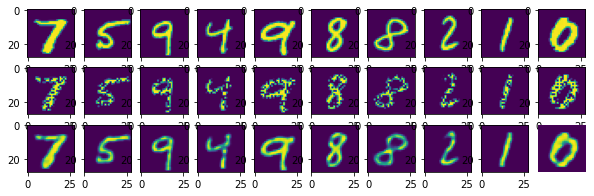

In [23]:
x = next(iter(train_dataloader))[0].view(-1, 784)
x_noise = masking_noise(x, 0.5)
pred_img = model(x_noise)
f, a = plt.subplots(3, 10, figsize=(10, 3))
plt.axis('off')
for i in range(10):
    a[0][i].imshow(np.reshape(x[i], (28, 28)))
    a[1][i].imshow(np.reshape(x_noise[i], (28, 28)))
    a[2][i].imshow(np.reshape(pred_img[i].detach(), (28, 28)))
plt.show()

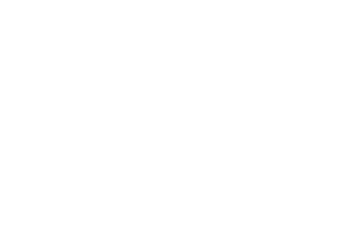

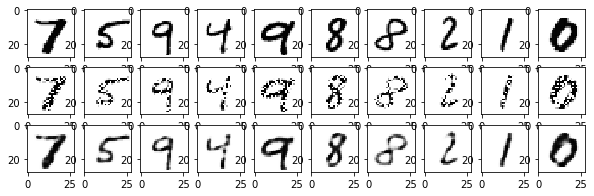

In [24]:
plt.axis('off')
f, a = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    a[0][i].imshow(np.reshape(x[i], (28, 28)), cmap='Greys',  interpolation='nearest')
    a[1][i].imshow(np.reshape(x_noise[i], (28, 28)), cmap='Greys',  interpolation='nearest')
    a[2][i].imshow(np.reshape(pred_img[i].detach(), (28, 28)), cmap='Greys',  interpolation='nearest')
plt.show()